<a href="https://colab.research.google.com/github/eleubner02/01-Stat-Arb-Pairs-Trading/blob/docs%2Frequirements-artifacts-license/notebooks/pairs_trading_analysis_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pairs Trading Strategy: Stat Arb

## Summary:

* Project: Cointegration-based Statistical Arbitrage on LUV–AAL (2020–2024)
* Method: OLS hedge ratio on log prices; residual z-score with shifted rolling stats; ENTRY=2.0, EXIT=0.5, z_window=60; time-stop=16 days; transaction costs 2 bps/leg on position changes.
* Results: Sharpe 1.54, unlevered annualized return 2.49%, max drawdown −1.32%, 30 completed trades, win rate 76.7%, average holding 11.7 days, 46.7% exits via time-stop.
* Notes: OLS beta b≈0.842, intercept≈1.278; ADF p≈0.027 on residual suggests stationarity.
* Robustness: Sensitivity across ENTRY/EXIT, z_window, and time-stop variants. Chosen config balanced Sharpe and trade frequency.

# 1. Configuration and Imports

In [ ]:
# !pip install yfinance

In [ ]:
# Parameters
stockA, stockB = 'LUV', 'AAL'
START_DATE, END_DATE = '2020-01-01', '2025-01-01'

ENTRY, EXIT = 2.0, 0.5
Z_WINDOW = 60
TIME_STOP_DAYS = 16

BPS_PER_LEG = 0.0002
INITIAL_CAPITAL = 100000.0
NOTIONAL_LONG_LEG = 10000.0  # dollars on the A leg

# Imports
import math, numpy as np, pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

pd.set_option('display.float_format', lambda x: f'{x:,.6f}')

# 2. Data Load

In [ ]:
prices = yf.download([stockA, stockB], start=START_DATE, end=END_DATE, progress=False)['Close']
prices = prices.dropna().sort_index()
assert set([stockA, stockB]).issubset(prices.columns)

/tmp/ipython-input-2067626206.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download([stockA, stockB], start=START_DATE, end=END_DATE, progress=False)['Close']


# 3. Hedge Ratio, Spread, ADF

[Explain here about these things]


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Align and log-transform

pxA = prices[stockA].dropna()
pxB = prices[stockB].dropna()
df = pd.concat([pxA, pxB], axis=1, keys=[stockA, stockB]).dropna()

logA = np.log(df[stockA])
logB = np.log(df[stockB])

# OLS: logA = a + b*logB

X = sm.add_constant(logB.values)
ols = sm.OLS(logA.values, X).fit()
a, b = ols.params[0], ols.params[1]

# Residual spread (stationary candidate)

spread = logA - (a + b*logB)

# 4. Z-Score Function

The z-score serves as our signal to trade. The z-score is a normalized measure, which coupled with thresholds, tells us when we are far enough from the mean spread to execute our strategy.

Hedge ratio b: 0.842, intercept a: 1.2778
ADF p-value on residual spread: 0.0268


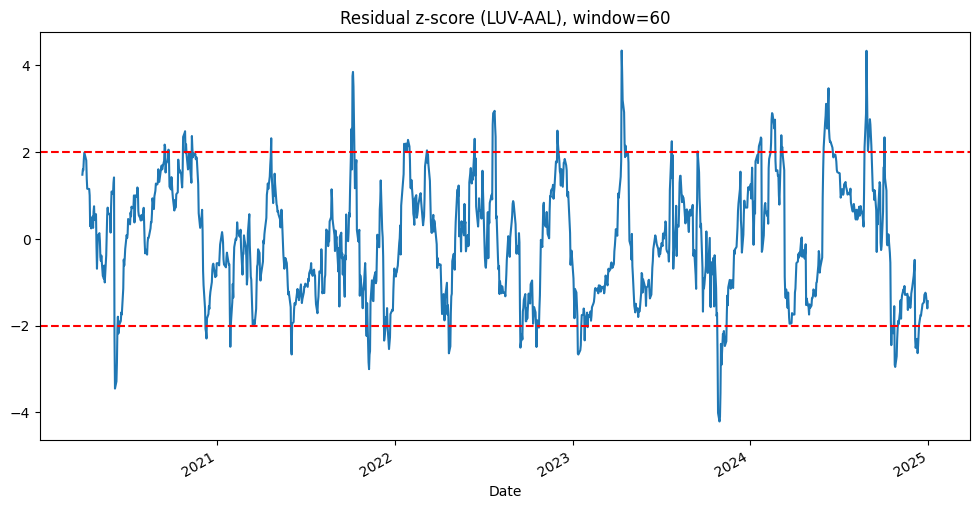

In [ ]:
# z-score function. .shift(1) is crucial because it prevents lookahead bias by only focusing on data before a given date
def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

z_window = 60
z = zscore(spread, window=z_window)
threshold = ENTRY

adf_p = adfuller(spread.dropna())[1]
cross_up = ((z.shift(1) <= threshold) & (z > threshold)).sum()
cross_dn = ((z.shift(1) >= -threshold) & (z < -threshold)).sum()

print(f"Hedge ratio b: {b:.3f}, intercept a: {a:.4f}")
print(f"ADF p-value on residual spread: {adf_p:.4f}")

# Plot (optional for a quick look):
ax = z.plot(figsize=(12,6), title=f"Residual z-score ({stockA}-{stockB}), window={z_window}")
ax.axhline(threshold, color='r', ls='--'); ax.axhline(-threshold, color='r', ls='--')

The above z-score visualization is powerful because it confirms the mean-reverting property of the spread.

# 5. Final Backtest Function



**Description:**
This feature implements a vectorized backtesting engine to simulate the performance of the statistical arbitrage pairs trading strategy. It iterates through historical price data on a daily basis, executes trades based on z-score signals, and tracks the portfolio's mark-to-market value over time.

**Core Logic:**
The engine operates on a daily loop with the following logic:
1.  **Initialization:** The backtest begins with a predefined starting capital and a 'FLAT' (no-risk) position.
2.  **Signal Generation:** Each day, it calculates the z-score of the pair's spread. If the z-score crosses a predefined entry threshold (e.g., >2.0 or <-2.0), a trade signal is generated.
3.  **Trade Execution:** On a signal, if no position is currently held, the engine simulates a trade. It allocates a fixed amount of capital (e.g., $10,000) to both the long and short legs of the pair, calculates the number of shares, and updates the cash balance. The position state is updated to 'LONG' or 'SHORT'.
4.  **Position Closing:** If a position is open and the z-score reverts toward the mean (e.g., `abs(z-score) < 0.5`), the position is closed. All holdings are sold at the current market price, cash is updated, and the position is reset to 'FLAT'.
5.  **Daily Mark-to-Market:** At the end of every day, the engine calculates the total portfolio value by summing the current cash balance and the market value of any shares held. This daily value is stored to generate an equity curve.

In [ ]:
def backtest_pairs(entry=ENTRY, exit_=EXIT, z_window=Z_WINDOW, time_stop_days=TIME_STOP_DAYS, use_time_stop=True,
                   initial_capital=INITIAL_CAPITAL, bps_per_leg=BPS_PER_LEG, notional_long_leg=NOTIONAL_LONG_LEG):
    # Build z and align
    z_local = zscore(spread, z_window).dropna()
    df_local = prices.loc[z_local.index]

    equity = initial_capital
    pos = 0
    shares_A = shares_B = 0
    trade_pnl = 0.0
    holding_days = 0

    dates_list, equity_list, trades_log = [], [], []

    def position_sizes_long_spread(beta, pA, pB, notionalA):
        shA = math.floor(notionalA / pA)
        shB = -math.floor(beta * notionalA / pB)
        return shA, shB

    def position_sizes_short_spread(beta, pA, pB, notionalA):
        shA = -math.floor(notionalA / pA)
        shB = math.floor(beta * notionalA / pB)
        return shA, shB

    def trade_cost(shA, pA, shB, pB, bps):
        traded_notional = abs(shA)*pA + abs(shB)*pB
        return bps * traded_notional

    dates = df_local.index
    for t in range(z_window, len(dates)):
        d = dates[t]
        pA_prev = df_local[stockA].iloc[t-1]
        pB_prev = df_local[stockB].iloc[t-1]
        pA = df_local[stockA].iloc[t]
        pB = df_local[stockB].iloc[t]

        # Accrue P&L
        if pos != 0:
            day_pnl = shares_A * (pA - pA_prev) + shares_B * (pB - pB_prev)
            equity += day_pnl
            trade_pnl += day_pnl
            holding_days += 1

        # Exit: revert or time-stop
        exit_signal = (pos != 0) and (abs(z_local.iloc[t]) < exit_)
        time_stop_hit = (pos != 0) and use_time_stop and (holding_days >= time_stop_days)
        if exit_signal or time_stop_hit:
            cost = trade_cost(shares_A, pA, shares_B, pB, bps_per_leg)
            equity -= cost
            trades_log.append({
                'date': d, 'action': 'EXIT', 'pos': pos, 'z': float(z_local.iloc[t]),
                'pnl': trade_pnl, 'cost': cost, 'holding_days': holding_days,
                'shares_A': shares_A, 'shares_B': shares_B, 'price_A': pA, 'price_B': pB,
                'reason': 'TIME_STOP' if time_stop_hit and not exit_signal else ('REVERT' if exit_signal and not time_stop_hit else 'REVERT+TIME_STOP')
            })
            pos = 0
            shares_A = shares_B = 0
            trade_pnl = 0.0
            holding_days = 0

        # Entry
        if pos == 0:
            if z_local.iloc[t] < -entry:
                shA, shB = position_sizes_long_spread(b, pA, pB, notional_long_leg)
                if shA != 0 and shB != 0:
                    cost = trade_cost(shA, pA, shB, pB, bps_per_leg)
                    equity -= cost
                    pos = 1
                    shares_A, shares_B = shA, shB
                    trade_pnl = 0.0
                    holding_days = 0
                    trades_log.append({'date': d, 'action': 'ENTER_LONG', 'pos': pos, 'z': float(z_local.iloc[t]),
                                       'cost': cost, 'shares_A': shares_A, 'shares_B': shares_B,
                                       'price_A': pA, 'price_B': pB})
            elif z_local.iloc[t] > entry:
                shA, shB = position_sizes_short_spread(b, pA, pB, notional_long_leg)
                if shA != 0 and shB != 0:
                    cost = trade_cost(shA, pA, shB, pB, bps_per_leg)
                    equity -= cost
                    pos = -1
                    shares_A, shares_B = shA, shB
                    trade_pnl = 0.0
                    holding_days = 0
                    trades_log.append({'date': d, 'action': 'ENTER_SHORT', 'pos': pos, 'z': float(z_local.iloc[t]),
                                       'cost': cost, 'shares_A': shares_A, 'shares_B': shares_B,
                                       'price_A': pA, 'price_B': pB})

        dates_list.append(d)
        equity_list.append(equity)

    trades_df = pd.DataFrame(trades_log)
    portfolio_df = pd.DataFrame({'Portfolio_Value': equity_list}, index=pd.DatetimeIndex(dates_list)).sort_index()
    portfolio_df['Daily_Return'] = portfolio_df['Portfolio_Value'].pct_change()
    daily = portfolio_df['Daily_Return'].dropna()

    sharpe = float(np.sqrt(252) * daily.mean() / daily.std()) if len(daily) else np.nan
    ann_return = float((1 + daily).prod()**(252/len(daily)) - 1) if len(daily) else np.nan
    portfolio_df['Peak'] = portfolio_df['Portfolio_Value'].cummax()
    portfolio_df['Drawdown'] = portfolio_df['Portfolio_Value'] / portfolio_df['Peak'] - 1
    max_dd = float(portfolio_df['Drawdown'].min())

    exits_df = trades_df[trades_df['action']=='EXIT'].copy() if not trades_df.empty else pd.DataFrame()
    win_rate = float((exits_df['pnl'] > 0).mean()) if not exits_df.empty else np.nan
    avg_hold = float(exits_df['holding_days'].mean()) if 'holding_days' in exits_df else np.nan
    time_stop_share = float((exits_df['reason'] == 'TIME_STOP').mean()) if 'reason' in exits_df else np.nan

    metrics = {'ENTRY': entry, 'EXIT': exit_, 'z_window': z_window, 'time_stop_days': time_stop_days,
               'Sharpe': sharpe, 'AnnRet': ann_return, 'MaxDD': max_dd, 'Trades': int(len(exits_df)),
               'WinRate': win_rate, 'AvgHoldDays': avg_hold, 'TimeStopShare': time_stop_share}
    return metrics, trades_df, portfolio_df, z_local

# 6. Final Backtest with Chosen Parameters

**Next Steps:**
- Plot the `portfolio_value_history` to visualize the strategy's equity curve.
- Calculate key performance metrics (e.g., Sharpe Ratio, Total Return, Max Drawdown)

In [ ]:
final_metrics, trades_df, portfolio_df, z_used = backtest_pairs(
    entry=ENTRY, exit_=EXIT, z_window=Z_WINDOW, time_stop_days=TIME_STOP_DAYS, use_time_stop=True
)
print(pd.Series(final_metrics))

ENTRY             2.000000
EXIT              0.500000
z_window         60.000000
time_stop_days   16.000000
Sharpe            1.540934
AnnRet            0.024941
MaxDD            -0.013193
Trades           30.000000
WinRate           0.766667
AvgHoldDays      11.733333
TimeStopShare     0.466667
dtype: float64


# 7. Plots

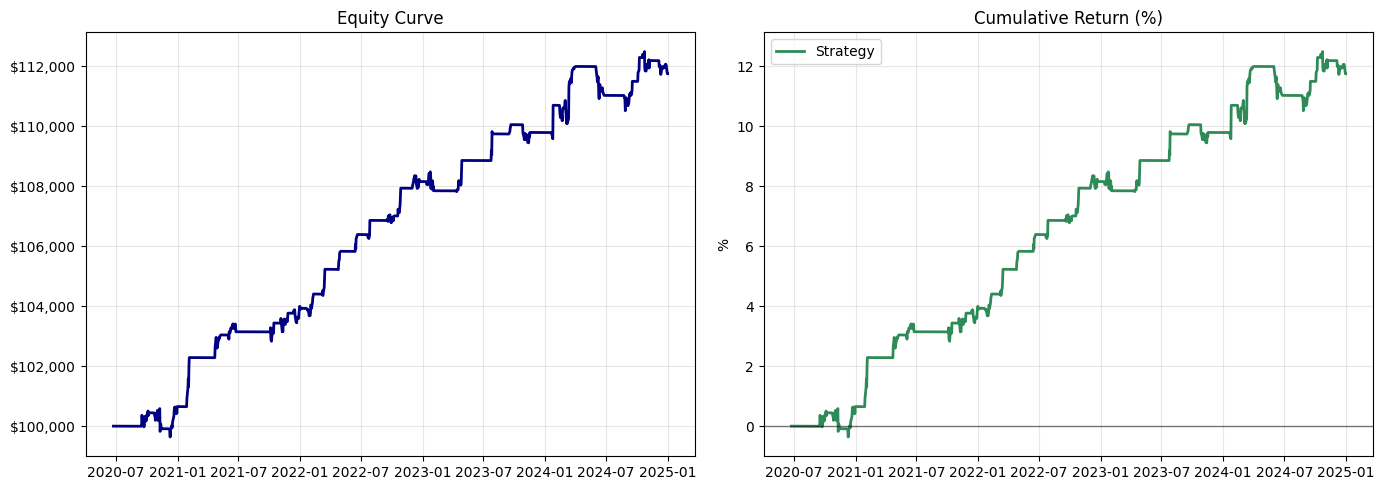

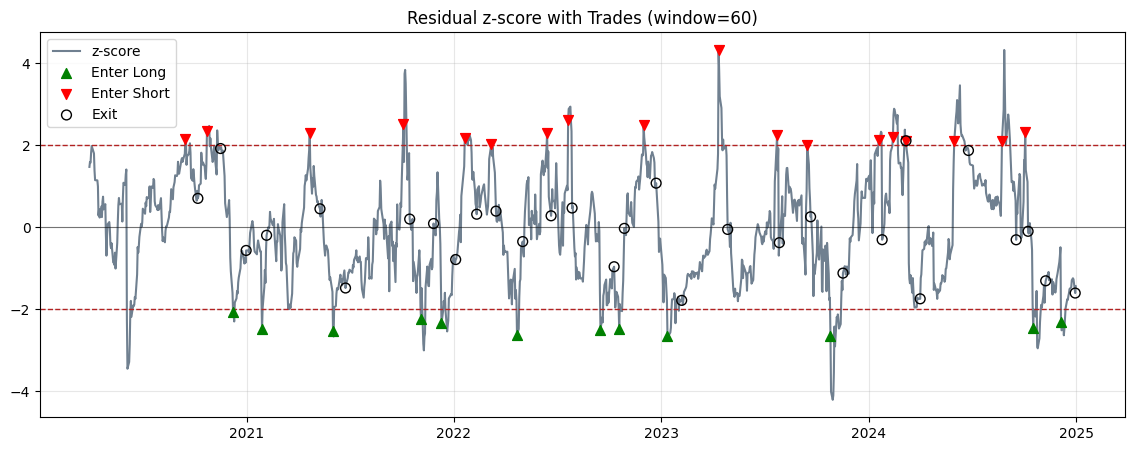

In [ ]:
# Equity curve + Cumulative returns
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(portfolio_df.index, portfolio_df['Portfolio_Value'], color='navy', lw=2)
ax[0].set_title('Equity Curve', fontsize=12)
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax[0].grid(True, alpha=0.3)

cum_ret = portfolio_df['Portfolio_Value'] / INITIAL_CAPITAL - 1.0
ax[1].plot(cum_ret.index, 100*cum_ret, color='seagreen', lw=2, label='Strategy')
ax[1].axhline(0, color='black', lw=1, alpha=0.5)
ax[1].set_title('Cumulative Return (%)', fontsize=12)
ax[1].set_ylabel('%')
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()

# z-score with trade markers
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(z_used.index, z_used.values, color='slategray', lw=1.5, label='z-score')
ax.axhline(ENTRY, color='firebrick', ls='--', lw=1)
ax.axhline(-ENTRY, color='firebrick', ls='--', lw=1)
ax.axhline(0, color='black', lw=0.8, alpha=0.5)

entries_long = trades_df[trades_df['action']=='ENTER_LONG']['date'] if 'action' in trades_df else []
entries_short = trades_df[trades_df['action']=='ENTER_SHORT']['date'] if 'action' in trades_df else []
exits = trades_df[trades_df['action']=='EXIT']['date'] if 'action' in trades_df else []

ax.scatter(entries_long, z_used.loc[entries_long], marker='^', color='green', s=50, label='Enter Long', zorder=3)
ax.scatter(entries_short, z_used.loc[entries_short], marker='v', color='red', s=50, label='Enter Short', zorder=3)
ax.scatter(exits, z_used.loc[exits], marker='o', facecolors='none', edgecolors='black', s=50, label='Exit', zorder=3)

ax.set_title(f'Residual z-score with Trades (window={final_metrics["z_window"]})', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# 8. Metrics Summary

* Results (2020–2024): Sharpe 1.54, unlevered annualized return 2.49%, max drawdown −1.32%.
* Trades: 30 completed, win rate 76.7%, average holding 11.7 days; 46.7% exits via time-stop.
* Costs: 2 bps/leg on entries/exits; applied only when positions change.
* Construction: Dollar-neutral sizing using OLS beta b≈0.842

# 9. Saving Artifacts

In [ ]:
trades_df.to_csv('trades.csv', index=False)



# Appendix

## A1: Screening (Code)



In [ ]:
stockA = 'PEP'
stockB = 'KO'

data = yf.download([stockA, stockB], start='2020-01-01', end='2025-01-01')

/tmp/ipython-input-308995636.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([stockA, stockB], start='2020-01-01', end='2025-01-01')
[*********************100%***********************]  2 of 2 completed


Next, I will perform the Engle-Granger test to check for cointegration. This is critical because a stationary spread is required for a mean-reverting strategy to be viable.

In [ ]:
test_statistic, p_value, critical_values = sm.tsa.stattools.coint(data['Close'][stockA], data['Close'][stockB], trend='c', method='aeg', maxlag=None, autolag='aic', return_results=None)

print(f"Cointegration Test Results:")
print(f"  Test Statistic: {test_statistic}")
print(f"  P-value: {p_value}")
print(f"  Critical Values (1%, 5%, 10%): {critical_values}")

if p_value < 0.05:
    print("\nBased on the p-value, we can reject the null hypothesis and conclude that ", stockA, " and ", stockB, " are likely cointegrated.")
else:
    print("\nBased on the p-value, we cannot reject the null hypothesis and there is not enough evidence to conclude that ", stockA, " and ", stockB, " are cointegrated.")

Cointegration Test Results:
  Test Statistic: -2.113590008000713
  P-value: 0.46926547016123027
  Critical Values (1%, 5%, 10%): [-3.90517395 -3.34099518 -3.04782579]

Based on the p-value, we cannot reject the null hypothesis and there is not enough evidence to conclude that  PEP  and  KO  are cointegrated.


### Cointegration Test Analysis

The Engle-Granger test resulted in a p-value of 0.469. The null hypothesis for this test is that the two series are not cointegrated. Since our p-value (0.469) is significantly greater than the standard significance level of 0.05, we fail to reject the null hypothesis.

**Conclusion:** There is no statistical evidence in this dataset to suggest that PEP and KO are cointegrated. Therefore, they are not a suitable pair for this pairs trading strategy.

Since PEP-KO failed cointegration, let's systematically find a better pair by iterating through a promising screening universe.

### Systematic Cointegration Screening

In [ ]:
screening_universe = {
    # Near-identical ETFs (highest probability)
    'gold_etfs': ['GLD', 'IAU'],
    'silver_etfs': ['SLV', 'SIVR'],

    # Sector ETFs
    'financials': ['XLF', 'KBE'],
    'energy': ['XLE', 'XOP'],

    # Classic pairs
    'major_banks': ['JPM', 'BAC'],
    'energy_majors': ['XOM', 'CVX'],
    'airlines': ['DAL', 'UAL', 'LUV', 'AAL'],
    'retail': ['WMT', 'TGT'],
}

# Download data for all tickers
all_tickers = []
for category_tickers in screening_universe.values():
    all_tickers.extend(category_tickers)
all_tickers = list(set(all_tickers))  # Remove duplicates

print(f"\nDownloading data for {len(all_tickers)} tickers...")
all_data = yf.download(all_tickers, start='2020-01-01', end='2025-01-01', progress=False)['Close']

# Store results
cointegration_results = []

# Test each category
for category, tickers in screening_universe.items():
    print(f"\nTesting {category}...")

    # Generate all pairs within category
    from itertools import combinations
    pairs = list(combinations(tickers, 2))

    for ticker1, ticker2 in pairs:
        try:
            # Get price series
            series1 = all_data[ticker1].dropna()
            series2 = all_data[ticker2].dropna()

            # Find common dates
            common_dates = series1.index.intersection(series2.index)
            if len(common_dates) < 252:  # Need at least 1 year
                continue

            # Align series
            s1 = series1[common_dates]
            s2 = series2[common_dates]

            # Run cointegration test
            test_stat, p_value, crit_values = sm.tsa.stattools.coint(s1, s2)

            # Store result
            cointegration_results.append({
                'pair': f"{ticker1}-{ticker2}",
                'ticker1': ticker1,
                'ticker2': ticker2,
                'category': category,
                'p_value': p_value,
                'test_stat': test_stat,
                'num_days': len(common_dates)
            })

            # Print if significant
            if p_value < 0.05:
                print(f"  ✓ Found cointegrated pair: {ticker1}-{ticker2} (p={p_value:.4f})")

        except Exception as e:
            print(f"  Error with {ticker1}-{ticker2}: {str(e)}")
            continue

# Create results dataframe and sort by p-value
results_df = pd.DataFrame(cointegration_results)
results_df = results_df.sort_values('p_value').reset_index(drop=True)

print("\n" + "-"*60)
print("TOP 10 CANDIDATES (sorted by p-value):")
print("-"*60)
print(results_df[['pair', 'category', 'p_value', 'num_days']].head(10))

# Select the best pair
if len(results_df[results_df['p_value'] < 0.05]) > 0:
    best_pair = results_df.iloc[0]
    print("\n" + "="*60)
    print(f"SELECTED PAIR: {best_pair['ticker1']} - {best_pair['ticker2']}")
    print(f"Category: {best_pair['category']}")
    print(f"P-value: {best_pair['p_value']:.4f}")
    print(f"Days of data: {best_pair['num_days']}")
    print("="*60)

    # Update your variables for the rest of the notebook
    stockA = best_pair['ticker1']
    stockB = best_pair['ticker2']

    # Re-download just this pair's data for consistency
    data = yf.download([stockA, stockB], start='2020-01-01', end='2025-01-01')
else:
    print("\nNo significant cointegrated pairs found.")

/tmp/ipython-input-3887400321.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  all_data = yf.download(all_tickers, start='2020-01-01', end='2025-01-01', progress=False)['Close']



Testing gold_etfs...

Testing silver_etfs...

Testing financials...

Testing energy...

Testing major_banks...

Testing energy_majors...

Testing airlines...

Testing retail...

------------------------------------------------------------
TOP 10 CANDIDATES (sorted by p-value):
------------------------------------------------------------
       pair       category  p_value  num_days
0   LUV-AAL       airlines 0.062487      1258
1   DAL-UAL       airlines 0.378505      1258
2   XOM-CVX  energy_majors 0.385614      1258
3   XLE-XOP         energy 0.456365      1258
4   GLD-IAU      gold_etfs 0.719782      1258
5   DAL-LUV       airlines 0.742016      1258
6  SLV-SIVR    silver_etfs 0.772771      1258
7   XLF-KBE     financials 0.801877      1258
8   UAL-LUV       airlines 0.853797      1258
9   DAL-AAL       airlines 0.873281      1258

No significant cointegrated pairs found.


While we still fall short of our desired significance level (0.05), the airline stock pair LUV-AAL shows a promising p-value of about 0.06. We also know airlines are economically linked through:

*   Fuel Costs
*   Regulatory Environment
*   Consumer demand patterns

Therefore, we have decent evidence of cointegration and economic sense for a pairs trading strategy, so our analysis will proceed with LUV-AAL.

## A2: Parameter sweeps (Code)

In [ ]:
# ===== Step 4A: Sweep ENTRY/EXIT with z_window fixed at 30 =====
import numpy as np
import pandas as pd
import statsmodels.api as sm
import math

stockA = 'LUV'
stockB = 'AAL'
prices = yf.download([stockA, stockB], start='2020-01-01', end='2025-01-01')['Close']

def run_backtest(entry, exit_, z_window=30, bps_per_leg=0.0002, notional_long_leg=10000.0):
    # Use the global 'prices' DataFrame which contains data for all tickers
    pxA_local = prices[stockA].dropna()
    pxB_local = prices[stockB].dropna()
    df_local = pd.concat([pxA_local, pxB_local], axis=1, keys=[stockA, stockB]).dropna()

    logA_local = np.log(df_local[stockA])
    logB_local = np.log(df_local[stockB])

    # OLS: logA = a + b*logB (recompute for the potentially filtered df_local)
    X_local = sm.add_constant(logB_local.values)
    ols_local = sm.OLS(logA_local.values, X_local).fit()
    a_local, b_local = ols_local.params[0], ols_local.params[1]

    # Residual spread (stationary candidate)
    spread_local = logA_local - (a_local + b_local*logB_local)
    z_local = zscore(spread_local, z_window).dropna()

    # Ensure df_local is aligned with the non-NaN z_local
    df_local = df_local.loc[z_local.index]


    # State
    initial_capital = 100000.0
    equity = initial_capital
    pos = 0
    shares_A = shares_B = 0
    trade_pnl = 0.0
    holding_days = 0

    portfolio_value_history = []
    dates_list = []
    trades_log_local = []

    def position_sizes_long_spread(beta, pA, pB, notionalA):
        shA = math.floor(notionalA / pA)
        shB = -math.floor(beta * notionalA / pB)
        return shA, shB

    def position_sizes_short_spread(beta, pA, pB, notionalA):
        shA = -math.floor(notionalA / pA)
        shB = math.floor(beta * notionalA / pB)
        return shA, shB

    def trade_cost(shA, pA, shB, pB, bps):
        traded_notional = abs(shA)*pA + abs(shB)*pB
        return bps * traded_notional

    dates = df_local.index
    # Start the loop from the first date in the aligned df_local
    for t in range(0, len(dates)):
        d = dates[t]
        # Need previous day's prices if not the very first day of the backtest window
        if t > 0:
            d_prev = dates[t-1]
            pA_prev = df_local[stockA].iloc[t-1]
            pB_prev = df_local[stockB].iloc[t-1]
        else: # For the first day, previous prices are the same as current
            pA_prev = df_local[stockA].iloc[t]
            pB_prev = df_local[stockB].iloc[t]


        pA = df_local[stockA].iloc[t]
        pB = df_local[stockB].iloc[t]


        # Accrue P&L
        if pos != 0:
            day_pnl = shares_A * (pA - pA_prev) + shares_B * (pB - pB_prev)
            equity += day_pnl
            trade_pnl += day_pnl
            holding_days += 1

        # Exit
        # Ensure z_local has a value for the current date t before checking exit condition
        if t < len(z_local) and pos != 0 and abs(z_local.iloc[t]) < exit_:
            cost = trade_cost(shares_A, pA, shares_B, pB, bps_per_leg)
            equity -= cost
            trades_log_local.append({
                'date': d, 'action': 'EXIT', 'pos': pos, 'z': float(z_local.iloc[t]),
                'pnl': trade_pnl, 'cost': cost, 'holding_days': holding_days,
                'shares_A': shares_A, 'shares_B': shares_B, 'price_A': pA, 'price_B': pB
            })
            pos = 0
            shares_A = shares_B = 0
            trade_pnl = 0.0
            holding_days = 0

        # Entry
        # Ensure z_local has a value for the current date t before checking entry condition
        if t < len(z_local) and pos == 0:
            if z_local.iloc[t] < -entry:
                shA, shB = position_sizes_long_spread(b_local, pA, pB, notional_long_leg)
                if shA != 0 and shB != 0:
                    cost = trade_cost(shA, pA, shB, pB, bps_per_leg)
                    equity -= cost
                    pos = 1
                    shares_A, shares_B = shA, shB
                    trade_pnl = 0.0
                    holding_days = 0
                    trades_log_local.append({
                        'date': d, 'action': 'ENTER_LONG', 'pos': pos, 'z': float(z_local.iloc[t]),
                        'cost': cost, 'shares_A': shares_A, 'shares_B': shares_B,
                        'price_A': pA, 'price_B': pB
                    })
            elif z_local.iloc[t] > entry:
                shA, shB = position_sizes_short_spread(b_local, pA, pB, notional_long_leg)
                if shA != 0 and shB != 0:
                    cost = trade_cost(shA, pA, shB, pB, bps_per_leg)
                    equity -= cost
                    pos = -1
                    shares_A, shares_B = shA, shB
                    trade_pnl = 0.0
                    holding_days = 0
                    trades_log_local.append({
                        'date': d, 'action': 'ENTER_SHORT', 'pos': pos, 'z': float(z_local.iloc[t]),
                        'cost': cost, 'shares_A': shares_A, 'shares_B': shares_B,
                        'price_A': pA, 'price_B': pB
                    })

        dates_list.append(d)
        portfolio_value_history.append(equity)

    # Metrics
    portfolio_df_local = pd.DataFrame({'Portfolio_Value': portfolio_value_history}, index=pd.DatetimeIndex(dates_list))
    daily = portfolio_df_local['Portfolio_Value'].pct_change().dropna()
    if len(daily) == 0:
        return {'ENTRY': entry, 'EXIT': exit_, 'Sharpe': np.nan, 'AnnRet': np.nan, 'MaxDD': np.nan, 'Trades': 0}

    sharpe = float(np.sqrt(252) * daily.mean() / daily.std())
    ann_return = float((1 + daily).prod()**(252/len(daily)) - 1)
    portfolio_df_local['Peak'] = portfolio_df_local['Portfolio_Value'].cummax()
    max_dd = float((portfolio_df_local['Portfolio_Value'] / portfolio_df_local['Peak'] - 1).min())

    trades_df_local = pd.DataFrame(trades_log_local)
    exits_local = trades_df_local[trades_df_local['action']=='EXIT'] if not trades_df_local.empty else pd.DataFrame()
    n_trades = int(len(exits_local))

    return {'ENTRY': entry, 'EXIT': exit_, 'Sharpe': sharpe, 'AnnRet': ann_return, 'MaxDD': max_dd, 'Trades': n_trades}

# Run the sweep
candidates = []
for ENTRY_ in [1.5, 2.0, 2.5]:
    for EXIT_ in [0.25, 0.5, 0.75]:
        candidates.append(run_backtest(ENTRY_, EXIT_, z_window=30))

res_df = pd.DataFrame(candidates).sort_values('Sharpe', ascending=False)
print(res_df.head(6).to_string(index=False))

/tmp/ipython-input-2677216400.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download([stockA, stockB], start='2020-01-01', end='2025-01-01')['Close']
[*********************100%***********************]  2 of 2 completed


   ENTRY     EXIT   Sharpe   AnnRet     MaxDD  Trades
2.500000 0.750000 0.630460 0.011773 -0.026287      30
1.500000 0.750000 0.626494 0.017710 -0.040363      61
2.500000 0.500000 0.617560 0.012276 -0.032251      30
2.000000 0.750000 0.615180 0.017075 -0.039218      44
1.500000 0.250000 0.610961 0.017715 -0.041040      43
2.500000 0.250000 0.582772 0.014921 -0.041763      26


In [ ]:
# ===== Step 4B: Test z_window ∈ {30, 60, 90} on top ENTRY/EXIT combos =====

import pandas as pd
import numpy as np
import statsmodels.api as sm # Import statsmodels

def run_backtest(entry, exit_, z_window=30, bps_per_leg=0.0002, notional_long_leg=10000.0):
    # Recompute spread and z for this window using the global df
    pxA_local = df[stockA].dropna()
    pxB_local = df[stockB].dropna()
    df_local_full = pd.concat([pxA_local, pxB_local], axis=1, keys=[stockA, stockB]).dropna()

    logA_local = np.log(df_local_full[stockA])
    logB_local = np.log(df_local_full[stockB])

    # OLS: logA = a + b*logB (recompute for the potentially filtered df_local_full)
    X_local = sm.add_constant(logB_local.values)
    ols_local = sm.OLS(logA_local.values, X_local).fit()
    a_local, b_local = ols_local.params[0], ols_local.params[1]

    # Residual spread (stationary candidate)
    spread_local = logA_local - (a_local + b_local*logB_local)
    z_local = zscore(spread_local, z_window).dropna()

    # Ensure df_local is aligned with the non-NaN z_local
    df_local = df_local_full.loc[z_local.index]


    # State
    initial_capital = 100000.0
    equity = initial_capital
    pos = 0
    shares_A = shares_B = 0
    trade_pnl = 0.0
    holding_days = 0

    portfolio_value_history = []
    dates_list = []
    trades_log_local = []

    import math
    def position_sizes_long_spread(beta, pA, pB, notionalA):
        shA = math.floor(notionalA / pA)
        shB = -math.floor(beta * notionalA / pB)
        return shA, shB

    def position_sizes_short_spread(beta, pA, pB, notionalA):
        shA = -math.floor(notionalA / pA)
        shB = math.floor(beta * notionalA / pB)
        return shA, shB

    def trade_cost(shA, pA, shB, pB, bps):
        traded_notional = abs(shA)*pA + abs(shB)*pB
        return bps * traded_notional

    dates = df_local.index
    # Start the loop from the first date in the aligned df_local
    for t in range(0, len(dates)):
        d = dates[t]
        # Need previous day's prices if not the very first day of the backtest window
        if t > 0:
            d_prev = dates[t-1]
            pA_prev = df_local[stockA].iloc[t-1]
            pB_prev = df_local[stockB].iloc[t-1]
        else: # For the first day, previous prices are the same as current
            pA_prev = df_local[stockA].iloc[t]
            pB_prev = df_local[stockB].iloc[t]


        pA = df_local[stockA].iloc[t]
        pB = df_local[stockB].iloc[t]

        # Accrue P&L
        if pos != 0:
            day_pnl = shares_A * (pA - pA_prev) + shares_B * (pB - pB_prev)
            equity += day_pnl
            trade_pnl += day_pnl
            holding_days += 1

        # Exit
        # Ensure z_local has a value for the current date t before checking exit condition
        if t < len(z_local) and pos != 0 and abs(z_local.iloc[t]) < exit_:
            cost = trade_cost(shares_A, pA, shares_B, pB, bps_per_leg)
            equity -= cost
            trades_log_local.append({
                'date': d, 'action': 'EXIT', 'pos': pos, 'z': float(z_local.iloc[t]),
                'pnl': trade_pnl, 'cost': cost, 'holding_days': holding_days,
                'shares_A': shares_A, 'shares_B': shares_B, 'price_A': pA, 'price_B': pB
            })
            pos = 0
            shares_A = shares_B = 0
            trade_pnl = 0.0
            holding_days = 0

        # Entry
        # Ensure z_local has a value for the current date t before checking entry condition
        if t < len(z_local) and pos == 0:
            if z_local.iloc[t] < -entry:
                shA, shB = position_sizes_long_spread(b_local, pA, pB, notional_long_leg)
                if shA != 0 and shB != 0:
                    cost = trade_cost(shA, pA, shB, pB, bps_per_leg)
                    equity -= cost
                    pos = 1
                    shares_A, shares_B = shA, shB
                    trade_pnl = 0.0
                    holding_days = 0
                    trades_log_local.append({
                        'date': d, 'action': 'ENTER_LONG', 'pos': pos, 'z': float(z_local.iloc[t]),
                        'cost': cost, 'shares_A': shares_A, 'shares_B': shares_B,
                        'price_A': pA, 'price_B': pB
                    })
            elif z_local.iloc[t] > entry:
                shA, shB = position_sizes_short_spread(b_local, pA, pB, notional_long_leg)
                if shA != 0 and shB != 0:
                    cost = trade_cost(shA, pA, shB, pB, bps_per_leg)
                    equity -= cost
                    pos = -1
                    shares_A, shares_B = shA, shB
                    trade_pnl = 0.0
                    holding_days = 0
                    trades_log_local.append({
                        'date': d, 'action': 'ENTER_SHORT', 'pos': pos, 'z': float(z_local.iloc[t]),
                        'cost': cost, 'shares_A': shares_A, 'shares_B': shares_B,
                        'price_A': pA, 'price_B': pB
                    })

        # Mark-to-market
        dates_list.append(d)
        portfolio_value_history.append(equity)

    # Metrics
    portfolio_df_local = pd.DataFrame({'Portfolio_Value': portfolio_value_history}, index=pd.DatetimeIndex(dates_list))
    daily = portfolio_df_local['Portfolio_Value'].pct_change().dropna()
    if len(daily) == 0:
        return {'ENTRY': entry, 'EXIT': exit_, 'z_window': z_window, 'Sharpe': np.nan, 'AnnRet': np.nan, 'MaxDD': np.nan, 'Trades': 0}

    sharpe = float(np.sqrt(252) * daily.mean() / daily.std())
    ann_return = float((1 + daily).prod()**(252/len(daily)) - 1)
    portfolio_df_local['Peak'] = portfolio_df_local['Portfolio_Value'].cummax()
    max_dd = float((portfolio_df_local['Portfolio_Value'] / portfolio_df_local['Peak'] - 1).min())

    trades_df_local = pd.DataFrame(trades_log_local)
    exits_local = trades_df_local[trades_df_local['action']=='EXIT'] if not trades_df_local.empty else pd.DataFrame()
    n_trades = int(len(exits_local))

    return {'ENTRY': entry, 'EXIT': exit_, 'z_window': z_window, 'Sharpe': sharpe, 'AnnRet': ann_return, 'MaxDD': max_dd, 'Trades': n_trades}

# Top threshold sets to test across windows
param_sets = [(2.5, 0.75), (2.5, 0.50), (1.5, 0.75)]
results = []
for zw in [30, 60, 90]:
    for entry, exit_ in param_sets:
        results.append(run_backtest(entry, exit_, z_window=zw))

res_w = pd.DataFrame(results).sort_values(['Sharpe', 'AnnRet'], ascending=False)
print(res_w.to_string(index=False))

   ENTRY     EXIT  z_window   Sharpe   AnnRet     MaxDD  Trades
2.500000 0.500000        60 0.980363 0.013248 -0.015727      15
1.500000 0.750000        60 0.831852 0.017739 -0.018216      41
2.500000 0.750000        60 0.778845 0.010164 -0.014905      15
2.500000 0.500000        90 0.770911 0.012366 -0.019186      12
2.500000 0.750000        30 0.630460 0.011773 -0.026287      30
1.500000 0.750000        30 0.626494 0.017710 -0.040363      61
2.500000 0.500000        30 0.617560 0.012276 -0.032251      30
2.500000 0.750000        90 0.599585 0.009101 -0.022210      12
1.500000 0.750000        90 0.524752 0.010505 -0.022292      27


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import math

def compute_half_life(z_series):
    z = pd.Series(z_series).dropna()
    # Regress z_t on z_{t-1}
    z_lag = z.shift(1).dropna()
    z_now = z.loc[z_lag.index]
    X = sm.add_constant(z_lag.values)
    res = sm.OLS(z_now.values, X).fit()
    phi = res.params[1]
    if 0 < phi < 1:
        hl = -np.log(2) / np.log(phi)
        return float(hl)
    else:
        return np.nan

def run_backtest(entry, exit_, z_window=60, bps_per_leg=0.0002, notional_long_leg=10000.0,
                 use_time_stop=True, time_stop_days=None):
    # Build z for this window
    z_local = zscore(spread, z_window).dropna()
    df_local = df.loc[z_local.index]

    # Half-life and time-stop
    if use_time_stop and time_stop_days is None:
        hl = compute_half_life(z_local)
        if np.isnan(hl):
            time_stop_days = 7  # fallback
        else:
            time_stop_days = int(np.clip(round(1.5 * hl), 3, 20))
    elif not use_time_stop:
        time_stop_days = None

    initial_capital = 100000.0
    equity = initial_capital
    pos = 0
    shares_A = shares_B = 0
    trade_pnl = 0.0
    holding_days = 0

    portfolio_value_history = []
    dates_list = []
    trades_log_local = []

    def position_sizes_long_spread(beta, pA, pB, notionalA):
        shA = math.floor(notionalA / pA)
        shB = -math.floor(beta * notionalA / pB)
        return shA, shB

    def position_sizes_short_spread(beta, pA, pB, notionalA):
        shA = -math.floor(notionalA / pA)
        shB = math.floor(beta * notionalA / pB)
        return shA, shB

    def trade_cost(shA, pA, shB, pB, bps):
        traded_notional = abs(shA)*pA + abs(shB)*pB
        return bps * traded_notional

    dates = df_local.index
    for t in range(z_window, len(dates)):
        d = dates[t]
        pA_prev = df_local[stockA].iloc[t-1]
        pB_prev = df_local[stockB].iloc[t-1]
        pA = df_local[stockA].iloc[t]
        pB = df_local[stockB].iloc[t]

        # Accrue P&L
        if pos != 0:
            day_pnl = shares_A * (pA - pA_prev) + shares_B * (pB - pB_prev)
            equity += day_pnl
            trade_pnl += day_pnl
            holding_days += 1

        # Exit: revert OR time-stop
        time_stop_hit = (time_stop_days is not None) and (holding_days >= time_stop_days) and (pos != 0)
        revert_hit = (pos != 0) and (abs(z_local.iloc[t]) < exit_)
        if time_stop_hit or revert_hit:
            cost = trade_cost(shares_A, pA, shares_B, pB, bps_per_leg)
            equity -= cost
            trades_log_local.append({
                'date': d, 'action': 'EXIT', 'pos': pos, 'z': float(z_local.iloc[t]),
                'pnl': trade_pnl, 'cost': cost, 'holding_days': holding_days,
                'shares_A': shares_A, 'shares_B': shares_B, 'price_A': pA, 'price_B': pB,
                'reason': 'TIME_STOP' if time_stop_hit and not revert_hit else ('REVERT' if revert_hit and not time_stop_hit else 'REVERT+TIME_STOP')
            })
            pos = 0
            shares_A = shares_B = 0
            trade_pnl = 0.0
            holding_days = 0

        # Entry
        if pos == 0:
            if z_local.iloc[t] < -entry:
                shA, shB = position_sizes_long_spread(b, pA, pB, notional_long_leg)
                if shA != 0 and shB != 0:
                    cost = trade_cost(shA, pA, shB, pB, bps_per_leg)
                    equity -= cost
                    pos = 1
                    shares_A, shares_B = shA, shB
                    trade_pnl = 0.0
                    holding_days = 0
                    trades_log_local.append({
                        'date': d, 'action': 'ENTER_LONG', 'pos': pos, 'z': float(z_local.iloc[t]),
                        'cost': cost, 'shares_A': shares_A, 'shares_B': shares_B,
                        'price_A': pA, 'price_B': pB
                    })
            elif z_local.iloc[t] > entry:
                shA, shB = position_sizes_short_spread(b, pA, pB, notional_long_leg)
                if shA != 0 and shB != 0:
                    cost = trade_cost(shA, pA, shB, pB, bps_per_leg)
                    equity -= cost
                    pos = -1
                    shares_A, shares_B = shA, shB
                    trade_pnl = 0.0
                    holding_days = 0
                    trades_log_local.append({
                        'date': d, 'action': 'ENTER_SHORT', 'pos': pos, 'z': float(z_local.iloc[t]),
                        'cost': cost, 'shares_A': shares_A, 'shares_B': shares_B,
                        'price_A': pA, 'price_B': pB
                    })

        dates_list.append(d)
        portfolio_value_history.append(equity)

    # Metrics
    portfolio_df_local = pd.DataFrame({'Portfolio_Value': portfolio_value_history}, index=pd.DatetimeIndex(dates_list))
    daily = portfolio_df_local['Portfolio_Value'].pct_change().dropna()
    if len(daily) == 0:
        return {'ENTRY': entry, 'EXIT': exit_, 'z_window': z_window, 'time_stop_days': time_stop_days,
                'Sharpe': np.nan, 'AnnRet': np.nan, 'MaxDD': np.nan, 'Trades': 0}

    sharpe = float(np.sqrt(252) * daily.mean() / daily.std())
    ann_return = float((1 + daily).prod()**(252/len(daily)) - 1)
    portfolio_df_local['Peak'] = portfolio_df_local['Portfolio_Value'].cummax()
    max_dd = float((portfolio_df_local['Portfolio_Value'] / portfolio_df_local['Peak'] - 1).min())

    trades_df_local = pd.DataFrame(trades_log_local)
    exits_local = trades_df_local[trades_df_local['action']=='EXIT'] if not trades_df_local.empty else pd.DataFrame()
    n_trades = int(len(exits_local))
    time_stop_share = float((exits_local['reason'] == 'TIME_STOP').mean()) if 'reason' in exits_local else np.nan

    return {
        'ENTRY': entry, 'EXIT': exit_, 'z_window': z_window, 'time_stop_days': time_stop_days,
        'Sharpe': sharpe, 'AnnRet': ann_return, 'MaxDD': max_dd, 'Trades': n_trades,
        'TimeStopShare': time_stop_share
    }

# Run with your current best params and time-stop enabled
res_base = run_backtest(entry=2.5, exit_=0.5, z_window=60, use_time_stop=False)
print(pd.Series(res_base))

res_ts8 = run_backtest(entry=2.5, exit_=0.5, z_window=60, use_time_stop=True, time_stop_days=8)
print(pd.Series(res_ts8))

res_ts16 = run_backtest(entry=2.5, exit_=0.5, z_window=60, use_time_stop=True, time_stop_days=16)
print(pd.Series(res_ts16))

res_base2 = run_backtest(entry=2.0, exit_=0.5, z_window=60, use_time_stop=False)
print(pd.Series(res_base2))

res_2p8 = run_backtest(entry=2.0, exit_=0.5, z_window=60, use_time_stop=True, time_stop_days=8)
print(pd.Series(res_2p8))

res_2p16 = run_backtest(entry=2.0, exit_=0.5, z_window=60, use_time_stop=True, time_stop_days=16)
print(pd.Series(res_2p16))

ENTRY             2.500000
EXIT              0.500000
z_window         60.000000
time_stop_days         NaN
Sharpe            0.861263
AnnRet            0.011467
MaxDD            -0.015902
Trades           14.000000
TimeStopShare     0.000000
dtype: float64
ENTRY             2.500000
EXIT              0.500000
z_window         60.000000
time_stop_days    8.000000
Sharpe            0.548498
AnnRet            0.004298
MaxDD            -0.010816
Trades           15.000000
TimeStopShare     0.866667
dtype: float64
ENTRY             2.500000
EXIT              0.500000
z_window         60.000000
time_stop_days   16.000000
Sharpe            0.634261
AnnRet            0.006522
MaxDD            -0.016439
Trades           15.000000
TimeStopShare     0.533333
dtype: float64
ENTRY             2.000000
EXIT              0.500000
z_window         60.000000
time_stop_days         NaN
Sharpe            1.344515
AnnRet            0.024527
MaxDD            -0.021027
Trades           26.000000
TimeStopSh